In [58]:
# Imports

import os
import shutil
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.metrics.classification import Accuracy, F1
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

In [59]:
# Getting our images in the right folders so we can use ImageFolder

project_path = os.getcwd().replace('/notebooks', '')
csv_path = project_path + '/data/HAM10000_metadata'
df = pd.read_csv(csv_path)

for index, row in df.iterrows():
    source = project_path + '/data/images/' + row['image_id'] + '.jpg'
    destination = project_path + '/data/images/' + row['dx'] + '/' + row['image_id'] + '.jpg'
    destination_folder = project_path + '/data/images/' + row['dx']
    if not os.path.exists(destination_folder):
        os.mkdir(destination_folder)
    if os.path.exists(source):
        shutil.move(source, destination)

In [60]:
# Setting up our dataloaders

val_size = 0.1
test_size = 0.899

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop((448, 576)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

ds = torchvision.datasets.ImageFolder(project_path + '/data/images2', transform=transform)
n_val = int(val_size * len(ds))
n_test = int(test_size * len(ds))
n_train = len(ds) - (n_val + n_test)
train_ds, val_ds, test_ds = random_split(ds, (n_train, n_val, n_test))

class_weights = [30.6, 19.5, 9.1, 87.1, 9.0, 1.5, 70.5]
train_ds_weights = [class_weights[label] for image, label in train_ds]
train_loader = DataLoader(train_ds, batch_size=11, num_workers=6, shuffle=True)
weighted_train_loader = DataLoader(train_ds, batch_size=11, num_workers=6, sampler=WeightedRandomSampler(train_ds_weights, len(train_ds), replacement=True))
val_loader = DataLoader(val_ds, batch_size=11, num_workers=6, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=11, num_workers=6, shuffle=False)

In [64]:
# Architecture specification

class Baseline(pl.LightningModule):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.lr = lr
        self.accuracy = Accuracy()
        self.f1 = F1()

        self.NN = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*18*14, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

        self.NN = nn.Sequential(
            nn.Flatten(),
            nn.Linear(448*576*3, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.NN(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
        return {
           'optimizer': optimizer,
           'lr_scheduler': scheduler,
           'monitor': 'val_loss'
        }

    def training_step(self, train_batch, batch_idx):
        x, y_true = train_batch
        y_pred = self.NN(x)
        loss = F.cross_entropy(y_pred, y_true)
        self.log('train_loss', loss, prog_bar=False)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y_true = val_batch
        y_pred = self.NN(x)
        loss = F.cross_entropy(y_pred, y_true.view(-1))
        acc = self.accuracy(torch.argmax(y_pred, dim=1), y_true.view(-1))
        f1 = self.f1(torch.argmax(y_pred, dim=1), y_true.view(-1))
        self.log('val_loss', loss, prog_bar=True)
        self.log('accuracy', acc, prog_bar=True)
        self.log('f1', f1, prog_bar=True)

In [74]:
# Init model and trainer

logger = CSVLogger("logs", name="Baseline", version='test')
callbacks = [
    #EarlyStopping('val_loss', patience=5),
    LearningRateMonitor(logging_interval='step'),
    ]
trainer = pl.Trainer(gpus=1, auto_lr_find=False, max_epochs=25, logger=logger, callbacks=callbacks)
model = Baseline(lr=1e-4)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [75]:
# Train

debug_ds_weights = [1.0 if i==0 or i==1 else 0.0 for i in range(len(train_ds))]
debug_loader = DataLoader(train_ds, batch_size=10, num_workers=6, sampler=WeightedRandomSampler(debug_ds_weights, len(train_ds), replacement=True))

trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | accuracy | Accuracy   | 0     
1 | f1       | F1         | 0     
2 | NN       | Sequential | 49.5 M
----------------------------------------
49.5 M    Trainable params
0         Non-trainable params
49.5 M    Total params
198.190   Total estimated model params size (MB)


Epoch 24: 100%|██████████| 22/22 [00:01<00:00, 11.56it/s, loss=0.0558, v_num=test, val_loss=1.390, accuracy=0.362, f1=0.362]


In [76]:
print(len(train_ds))
print(train_ds[0][1])
print(train_ds[1][1])
print(train_ds[2][1])
model.eval()
with torch.no_grad():
    print(model(train_ds[0][0].unsqueeze(0)))
    print(model(train_ds[1][0].unsqueeze(0)))
    print(model(train_ds[2][0].unsqueeze(0)))

3
1
0
1
tensor([[-14.0128, -11.5195]])
tensor([[ -8.7851, -11.5739]])
tensor([[-16.5549, -12.9116]])


<AxesSubplot:>

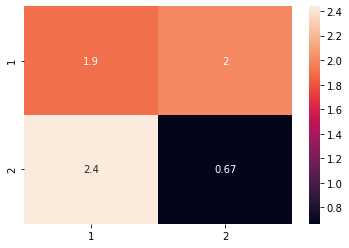

In [77]:
# Confusion matrix

val_ds_weights = [class_weights[label] for image, label in val_ds]
weighted_val_loader = DataLoader(val_ds, batch_size=25, num_workers=6, sampler=WeightedRandomSampler(val_ds_weights, len(val_ds), replacement=True))

y_pred = []
y_true = []

# iterate over validation data
model.eval()
with torch.no_grad():
        for inputs, labels in weighted_val_loader:
                logits = model(inputs) # Feed Network

                output = (torch.max(torch.exp(logits), 1))[1].cpu().numpy()
                y_pred.extend(output) # Save Prediction
                
                labels = labels.data.cpu().numpy()
                y_true.extend(labels) # Save Truth

# constant for classes
classes = ('akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc')
classes = [1, 2]

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix)*7, index = [i for i in classes], columns = [i for i in classes])
sns.heatmap(df_cm, annot=True)